In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
%matplotlib inline
from casadi import *
from pdfo import *

In [5]:
n = 500
taux = 1/n

In [8]:
def Unicycle_DOC ( Xi , Xf , c1 , c2) :
    x1i = Xi[0] 
    x2i = Xi[1]
    x3i = Xi[2]
    
    x1f = Xf[0] 
    x2f = Xf[1]
    x3f = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)

    opti.minimize(   (taux/2)*(c1*dot(u1,u1)+c2*dot(u2,u2))   )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x1[0]==x1i + 10**(-4))        
    opti.subject_to( x2[0]==x2i + 10**(-4))
    opti.subject_to( x3[0]==x3i + 10**(-4))
    
    opti.subject_to( u1[0] == 0.0001 )
    opti.subject_to( u2[0] == 0.0001 )

    opti.subject_to( u1[-1] == 0.0001)
    opti.subject_to( u2[-1] == 0.0001)

    ## pour les contraintes d'égaliter
    opti.subject_to( x1[:n-1]+taux*u1[:n-1]*cos(x3[:n-1])==x1[1:] + 10**(-4))
    opti.subject_to( x2[:n-1]+taux*u1[:n-1]*sin(x3[:n-1])==x2[1:] + 10**(-4))
    opti.subject_to( x3[:n-1]+taux*u2[:n-1] ==x3[1:] + 10**(-4))

    ## pour les conditions finales
    opti.subject_to( x1[-1]==x1f + 10**(-4))
    opti.subject_to( x2[-1]==x2f + 10**(-4))
    opti.subject_to( x3[-1]==x3f + 10**(-4))


    opti.solver('ipopt')      # suivant la méthode de KKT


    sol = opti.solve()
    
    X1 = sol.value(x1)
    X2 = sol.value(x2)
    X3 = sol.value(x3)
    
    U1 = sol.value(u1)
    U2 = sol.value(u2)
    
    return X1,X2,X3,U1,U2

In [9]:
bounds = np.array([[0, 1], [0, 1]])
lin_con = LinearConstraint([1, 1], 1, 1)

options = {'maxfev': 300 , 'rhobeg' : 0.01 , 'rhoend' : 1e-6}


def Unicycle (C) :
    [C1,C2] = C
    print(C)
    
    #if C1 < 0 or C2 < 0 or C1 > 1 or C2 > 1 or C1 + C2 != 1 :
     #   return 500 
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)

    opti.minimize(   (taux/2)*(C1*dot(u1,u1)+C2*dot(u2,u2))   )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x1[0]==X1[0] + 10**(-4))        
    opti.subject_to( x2[0]==X2[0] + 10**(-4))
    opti.subject_to( x3[0]==X3[0] + 10**(-4))
    
    opti.subject_to( u1[0] == 0.0001 )
    opti.subject_to( u2[0] == 0.0001 )
    opti.subject_to( u1[-1] == 0.0001)
    opti.subject_to( u2[-1] == 0.0001)
    
    for j in range (n):
        opti.subject_to( u1[j] < 10 )
        opti.subject_to( u1[j] > -10 )
        
        opti.subject_to( u2[j] < 20 )
        opti.subject_to( u2[j] > -20 )
        
    

    ## pour les contraintes d'égaliter
    opti.subject_to( u1[:n-1]*cos(x3[:n-1])==(x1[1:] + 10**(-4) - x1[:n-1])/taux)
    opti.subject_to( u1[:n-1]*sin(x3[:n-1])==(x2[1:] + 10**(-4) - x2[:n-1])/taux)
    opti.subject_to( u2[:n-1] ==(x3[1:] + 10**(-4) - x3[:n-1])/taux)
    
    ## pour les conditions finales
    opti.subject_to( x1[-1]==X1[-1] + 10**(-4))
    opti.subject_to( x2[-1]==X2[-1] + 10**(-4))
    opti.subject_to( x3[-1]==X3[-1] + 10**(-4))
    
    opti.solver('ipopt', {"expand":True}, {"max_iter":10000})
    
    sol = opti.solve() 
    
    X1_1 = opti.debug.value(x1)
    X2_1 = opti.debug.value(x2)
    X3_1 = opti.debug.value(x3)
    
    plt.plot(X1_1,X2_1, color = 'green')
    
    m1 = sqrt((np.linalg.norm(X1-X1_1)**2 + np.linalg.norm(X2-X2_1)**2 + np.linalg.norm(X3-X3_1)**2 )/n)
    
    return m1   


In [10]:
def DOC_Unicycle_PDFO (Xi, Xf, C1,C2):

    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)

    opti.minimize(   (taux/2)*(C1*dot(u1,u1)+C2*dot(u2,u2))   )    # ma fonction objetion

        # mes fonctions de contrainte d'égalité:

        ## pour les condition initial
    opti.subject_to( x1[0]==Xi[0] + 10**(-4))        
    opti.subject_to( x2[0]==Xi[1] + 10**(-4))
    opti.subject_to( x3[0]==Xi[2] + 10**(-4))

    opti.subject_to( u1[0] == 0.0001 )
    opti.subject_to( u2[0] == 0.0001 )
    opti.subject_to( u1[-1] == 0.0001)
    opti.subject_to( u2[-1] == 0.0001)

    for j in range (n):
        opti.subject_to( u1[j] < 10 )
        opti.subject_to( u1[j] > -10 )

        opti.subject_to( u2[j] < 20 )
        opti.subject_to( u2[j] > -20 )



        ## pour les contraintes d'égaliter
    opti.subject_to( u1[:n-1]*cos(x3[:n-1])==(x1[1:] + 10**(-4) - x1[:n-1])/taux)
    opti.subject_to( u1[:n-1]*sin(x3[:n-1])==(x2[1:] + 10**(-4) - x2[:n-1])/taux)
    opti.subject_to( u2[:n-1] ==(x3[1:] + 10**(-4) - x3[:n-1])/taux)

        ## pour les conditions finales
    opti.subject_to( x1[-1]==Xf[0] + 10**(-4))
    opti.subject_to( x2[-1]==Xf[1] + 10**(-4))
    opti.subject_to( x3[-1]==Xf[2] + 10**(-4))

    opti.solver('ipopt', {"expand":True}, {"max_iter":10000})

    sol = opti.solve() 

    X01 = opti.debug.value(x1)
    X02 = opti.debug.value(x2)
    X03 = opti.debug.value(x3)
    
    
    return X01,X02,X03


In [11]:
Xi = [-4,-0.9,pi]
Xf = [0,0,pi/2]
c1 = 0.25
c2 = 0.75

X1,X2,X3,U1,U2 = Unicycle_DOC ( Xi , Xf , c1 , c2)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality co

[0.5 0.5]
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 

   9  1.3893789e+01 2.16e-01 7.63e+06  -1.0 4.22e+00   5.2 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4093374e+01 1.69e-03 2.13e+05  -1.0 8.39e-02   5.6 1.00e+00 1.00e+00h  1
  11  1.4095210e+01 1.05e-07 1.50e+02  -1.0 1.09e-03   5.1 1.00e+00 1.00e+00h  1
  12  1.4095210e+01 2.15e-13 4.65e-03  -1.0 1.05e-07   4.6 1.00e+00 1.00e+00h  1
  13  1.4095210e+01 2.14e-13 1.28e-03  -2.5 8.67e-08   4.2 1.00e+00 1.00e+00h  1
  14  1.3818383e+01 1.77e+00 5.40e-03  -3.8 7.72e+00    -  5.35e-01 5.00e-01f  2
  15  1.3594953e+01 1.66e+00 5.22e-03  -3.8 7.95e+00    -  5.63e-01 2.50e-01h  3
  16  1.3491806e+01 1.58e+00 5.09e-03  -3.8 8.81e+00    -  7.36e-01 2.50e-01h  3
  17  1.3455846e+01 1.56e+00 4.90e-03  -3.8 1.05e+01    -  9.19e-01 2.10e-01h  3
  18  1.3383169e+01 1.50e+00 4.68e-03  -3.8 1.46e+01    -  5.10e-01 7.40e-02h  4
  19  1.3344091e+01 1.47e+00 4.59e-03  -3.8 2.38e+01    -  8.00e-01 4.45e-02h  4
iter    objective    inf_pr 

  26  1.0766863e+01 2.12e-01 3.01e+04  -3.8 2.15e+00   3.7 4.70e-05 1.00e+00h  1
  27  1.0651882e+01 1.24e-03 3.72e+03  -3.8 8.39e-02   4.1 9.97e-01 1.00e+00h  1
  28  1.0653217e+01 4.63e-08 2.73e+00  -3.8 6.23e-04   3.6 1.00e+00 1.00e+00h  1
  29  1.0653217e+01 2.07e-13 1.03e-03  -3.8 7.06e-07   3.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0653216e+01 2.19e-13 1.05e-03  -5.7 2.15e-06   2.7 1.00e+00 1.00e+00h  1
  31  1.0653213e+01 1.64e-12 1.05e-03  -5.7 6.45e-06   2.2 1.00e+00 1.00e+00h  1
  32  1.0653204e+01 1.46e-11 1.05e-03  -5.7 1.94e-05   1.7 1.00e+00 1.00e+00h  1
  33  1.0653176e+01 1.31e-10 1.05e-03  -5.7 5.81e-05   1.3 1.00e+00 1.00e+00h  1
  34  1.0653092e+01 1.18e-09 1.05e-03  -5.7 1.74e-04   0.8 1.00e+00 1.00e+00h  1
  35  1.0652841e+01 1.06e-08 1.05e-03  -5.7 5.23e-04   0.3 1.00e+00 1.00e+00h  1
  36  1.0652088e+01 9.54e-08 1.05e-03  -5.7 1.57e-03  -0.2 1.00e+00 1.00e+00h  1
  37  1.0649833e+01 8.57e-07

  43  9.5180529e+00 6.71e-01 1.71e-03  -5.7 1.86e+00  -3.5 1.00e+00 1.00e+00h  1
  44  9.3901161e+00 2.11e+00 3.43e-02  -5.7 6.10e+00  -4.0 1.00e+00 1.00e+00H  1
  45  7.7869163e+00 3.51e-01 2.37e-03  -5.7 1.80e+00    -  1.00e+00 1.00e+00h  1
  46  7.7306986e+00 1.40e-02 4.73e-05  -5.7 3.17e-01    -  1.00e+00 1.00e+00h  1
  47  7.7303048e+00 1.05e-05 1.92e-08  -5.7 8.12e-03    -  1.00e+00 1.00e+00h  1
  48  7.7303043e+00 2.29e-09 2.71e-11  -8.6 1.35e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:   7.7303042679064626e+00    7.7303042679064626e+00
Dual infeasibility......:   2.7069013697200717e-11    2.7069013697200717e-11
Constraint violation....:   4.5891201949643801e-10    2.2945600974821900e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5287129101910191e-09    2.5287129101910191e-09
Overall NLP error.......:  

[0.49292893 0.50707107]
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00  

  19  1.3195732e+01 1.64e+00 5.02e-03  -3.8 4.07e+01    -  3.81e-01 2.56e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3171725e+01 1.62e+00 5.02e-03  -3.8 5.87e+01    -  1.79e-01 1.81e-02h  4
  21  1.3154440e+01 1.61e+00 5.05e-03  -3.8 1.05e+02    -  1.13e-01 1.02e-02h  4
  22  1.3132207e+01 1.59e+00 5.95e-03  -3.8 1.06e+02    -  2.51e-01 1.03e-02h  4
  23  1.3114698e+01 1.37e+00 5.65e-03  -3.8 2.21e+01    -  1.00e+00 1.06e-01h  3
  24  1.1527188e+01 3.78e-02 2.67e+03  -3.8 5.41e-01   3.7 8.45e-01 1.00e+00h  1
  25  1.1514109e+01 1.33e-05 8.70e+01  -3.8 1.09e-02   3.2 1.00e+00 1.00e+00h  1
  26  1.1514137e+01 1.38e-11 5.59e-03  -3.8 1.02e-05   2.7 1.00e+00 1.00e+00h  1
  27  1.1514136e+01 4.65e-13 2.68e-04  -3.8 1.47e-06   2.3 1.00e+00 1.00e+00h  1
  28  1.1514135e+01 3.69e-12 2.69e-04  -5.7 4.41e-06   1.8 1.00e+00 1.00e+00h  1
  29  1.1514131e+01 3.23e-11 2.69e-04  -5.7 1.32e-05   1.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  39  8.6956808e+00 2.22e+00 1.04e-02  -5.7 4.32e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  7.7373746e+00 5.26e-01 1.43e-03  -5.7 1.91e+00    -  1.00e+00 1.00e+00h  1
  41  7.6244151e+00 7.01e-03 9.46e-06  -5.7 2.18e-01    -  1.00e+00 1.00e+00h  1
  42  7.6253908e+00 1.67e-07 1.77e-09  -5.7 1.78e-03    -  1.00e+00 1.00e+00h  1
  43  7.6253910e+00 2.67e-09 3.02e-11  -8.6 1.48e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   7.6253909602856060e+00    7.6253909602856060e+00
Dual infeasibility......:   3.0162539133016253e-11    3.0162539133016253e-11
Constraint violation....:   5.3477955397340793e-10    2.6738977698670396e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5325536678753650e-09    2.5325536678753650e-09
Overall NLP error.......:  

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  16  1.0296003e+01 1.20e-01 9.56e+03  -3.8 9.60e-01   3.7 9.32e-03 1.00e+00h  1
  17  1.0283806e+01 4.11e-04 1.19e+03  -3.8 3.28e-02   3.2 1.00e+00 1.00e+00h  1
  18  1.0284342e+01 4.21e-09 1.21e-01  -3.8 2.21e-04   2.7 1.00e+00 1.00e+00h  1
  19  1.0284341e+01 1.31e-12 6.23e-04  -3.8 3.41e-06   2.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0284338e+01 1.18e-11 6.31e-04  -5.7 1.04e-05   1.8 1.00e+00 1.00e+00h  1
  21  1.0284328e+01 1.06e-10 6.31e-04  -5.7 3.11e-05   1.3 1.00e+00 1.00e+00h  1
  22  1.0284300e+01 9.55e-10 6.31e-04  -5.7 9.33e-05   0.8 1.00e+00 1.00e+00h  1
  23  1.0284213e+01 8.60e-09 6.31e-04  -5.7 2.80e-04   0.4 1.00e+00 1.00e+00h  1
  24  1.0283954e+01 7.74e-08 6.31e-04  -5.7 8.39e-04  -0.1 1.00e+00 1.00e+00h  1
  25  1.0283178e+01 6.97e-07 6.30e-04  -5.7 2.51e-03  -0.6 1.00e+00 1.00e+00h  1
  26  1.0280857e+01 6.27e-06 6.28e-04  -5.7 7.52e-03  -1.1 1.00e+00 1.00e+00h  1
  27  1.0273963e+01 5.65e-05

[0.24393398 0.75606602]
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00  

  12  1.4885642e+01 2.06e-13 5.10e-03  -1.0 1.15e-07   4.6 1.00e+00 1.00e+00h  1
  13  1.4885642e+01 2.12e-13 1.91e-03  -2.5 1.29e-07   4.2 1.00e+00 1.00e+00h  1
  14  1.4885641e+01 2.14e-13 1.87e-03  -3.8 3.80e-07   3.7 1.00e+00 1.00e+00h  1
  15  1.4885640e+01 2.71e-13 1.87e-03  -3.8 1.14e-06   3.2 1.00e+00 1.00e+00h  1
  16  1.4885637e+01 9.84e-13 1.87e-03  -3.8 3.42e-06   2.7 1.00e+00 1.00e+00h  1
  17  1.4885627e+01 7.28e-12 1.87e-03  -3.8 1.02e-05   2.3 1.00e+00 1.00e+00h  1
  18  1.4885598e+01 6.44e-11 1.87e-03  -3.8 3.07e-05   1.8 1.00e+00 1.00e+00h  1
  19  1.4885509e+01 5.78e-10 1.87e-03  -3.8 9.22e-05   1.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.4885244e+01 5.20e-09 1.87e-03  -3.8 2.77e-04   0.8 1.00e+00 1.00e+00f  1
  21  1.4884447e+01 4.68e-08 1.87e-03  -3.8 8.30e-04   0.4 1.00e+00 1.00e+00f  1
  22  1.4882057e+01 4.21e-07 1.87e-03  -3.8 2.49e-03  -0.1 1.00e+00 1.00e+00f  1
  23  1.4874895e+01 3.79e-06

  31  8.2473776e+00 1.04e-01 5.14e-04  -5.7 1.53e+00  -3.5 1.00e+00 3.96e-01h  1
  32  8.0419312e+00 1.57e-01 5.56e-04  -5.7 5.67e+00  -3.9 1.00e+00 1.09e-01h  1
  33  7.7802516e+00 3.32e-01 1.18e-03  -5.7 5.76e+01  -4.4 1.57e-01 1.90e-02f  1
  34  7.3668251e+00 1.45e+00 2.31e-03  -5.7 7.56e+00  -4.0 1.00e+00 3.56e-01h  1
  35  7.0529106e+00 2.12e+00 3.08e-03  -5.7 3.96e+01  -4.5 2.69e-02 6.66e-02h  3
  36  6.8318771e+00 2.32e+00 2.92e-03  -5.7 2.41e+01    -  2.09e-02 1.08e-01h  3
  37  5.7959765e+00 5.29e-01 3.78e-03  -5.7 4.18e+00    -  3.91e-02 1.00e+00h  1
  38  5.5948649e+00 9.40e-02 1.58e-03  -5.7 2.17e+00    -  3.78e-02 1.00e+00h  1
  39  5.5295049e+00 4.75e-03 7.56e-04  -5.7 2.01e+00    -  1.76e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.5252813e+00 3.41e-04 5.00e-05  -5.7 1.56e+00    -  5.91e-01 1.00e+00h  1
  41  5.5251417e+00 7.99e-07 1.45e-08  -5.7 4.96e-02    -  1.00e+00 1.00e+00h  1
  42  5.5251416e+00 2.43e-08

[0.23686292 0.76313708]
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00  

  14  1.4194477e+01 8.94e+00 4.40e-02  -3.8 1.70e+01    -  2.23e-01 5.44e-01F  1
  15  1.4057289e+01 8.92e+00 4.40e-02  -3.8 6.98e+02    -  9.76e-03 3.02e-03h  1
  16  1.0068048e+01 3.88e-01 2.20e+04  -3.8 1.58e+00   3.7 7.39e-06 1.00e+00f  1
  17  9.9067266e+00 4.45e-03 4.60e+03  -3.8 1.16e-01   3.2 1.00e+00 1.00e+00h  1
  18  9.9112578e+00 6.80e-07 1.08e+00  -3.8 1.96e-03   2.7 1.00e+00 1.00e+00h  1
  19  9.9112557e+00 1.52e-12 7.26e-04  -3.8 3.97e-06   2.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.9112503e+00 1.27e-11 7.45e-04  -5.7 1.22e-05   1.8 1.00e+00 1.00e+00h  1
  21  9.9112343e+00 1.14e-10 7.45e-04  -5.7 3.67e-05   1.3 1.00e+00 1.00e+00h  1
  22  9.9111863e+00 1.02e-09 7.45e-04  -5.7 1.10e-04   0.8 1.00e+00 1.00e+00h  1
  23  9.9110423e+00 9.22e-09 7.45e-04  -5.7 3.30e-04   0.4 1.00e+00 1.00e+00h  1
  24  9.9106104e+00 8.29e-08 7.45e-04  -5.7 9.90e-04  -0.1 1.00e+00 1.00e+00h  1
  25  9.9093164e+00 7.46e-07

  38  5.9640012e+00 5.90e-01 1.82e-03  -5.7 2.77e+00    -  4.08e-02 1.00e+00h  1
  39  5.7365146e+00 4.41e-02 1.34e-03  -5.7 2.49e+00    -  8.69e-02 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7233140e+00 1.36e-03 2.15e-04  -5.7 2.00e+00    -  2.85e-01 1.00e+00h  1
  41  5.7225949e+00 2.88e-05 8.00e-06  -5.7 4.19e-01    -  9.20e-01 1.00e+00h  1
  42  5.7225890e+00 7.71e-09 3.59e-10  -5.7 9.11e-03    -  1.00e+00 1.00e+00h  1
  43  5.7225890e+00 2.21e-08 1.20e-10  -8.6 4.51e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   5.7225889685792053e+00    5.7225889685792053e+00
Dual infeasibility......:   1.2025225260003936e-10    1.2025225260003936e-10
Constraint violation....:   4.4281781352850663e-09    2.2140890676425329e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity........

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  11  1.4585097e+01 1.05e-07 1.50e+02  -1.0 1.09e-03   5.1 1.00e+00 1.00e+00h  1
  12  1.4585098e+01 2.13e-13 4.95e-03  -1.0 1.11e-07   4.6 1.00e+00 1.00e+00h  1
  13  1.4585097e+01 2.06e-13 1.69e-03  -2.5 1.14e-07   4.2 1.00e+00 1.00e+00h  1
  14  1.4243429e+01 9.26e+00 4.36e-02  -3.8 1.78e+01    -  2.15e-01 5.26e-01F  1
  15  1.0343435e+01 3.64e-01 2.31e+04  -3.8 1.60e+00   3.7 2.28e-03 1.00e+00h  1
  16  1.0165728e+01 4.66e-03 4.94e+03  -3.8 1.17e-01   3.2 1.00e+00 1.00e+00h  1
  17  1.0170289e+01 6.93e-07 1.14e+00  -3.8 2.08e-03   2.7 1.00e+00 1.00e+00h  1
  18  1.0170287e+01 1.76e-12 7.94e-04  -3.8 4.35e-06   2.3 1.00e+00 1.00e+00h  1
  19  1.0145770e+01 1.98e+00 4.07e-03  -5.7 3.57e+02    -  1.81e-02 1.15e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2278837e+00 2.66e-02 3.55e+01  -5.7 4.58e-01   1.8 1.23e-05 1.00e+00h  1
  21  9.2194337e+00 5.11e-06 5.03e-01  -5.7 7.19e-03   1.3 1.00e+00 1.00e+00h  1
  22  9.2193878e+00 1.25e-09

  34  7.6628916e+00 1.36e+00 2.33e-03  -5.7 8.41e+00  -4.0 1.00e+00 3.08e-01h  1
  35  7.3688983e+00 2.11e+00 3.29e-03  -5.7 1.10e+02  -4.5 1.15e-02 2.40e-02h  3
  36  7.1908200e+00 2.46e+00 3.36e-03  -5.7 7.09e+01    -  8.12e-03 3.66e-02h  3
  37  6.3283198e+00 1.16e+00 6.54e-03  -5.7 4.35e+00    -  5.14e-02 1.00e+00h  1
  38  5.8938756e+00 3.84e-01 1.82e-03  -5.7 2.87e+00    -  3.15e-02 1.00e+00h  1
  39  5.7268531e+00 2.75e-02 1.22e-03  -5.7 2.52e+00    -  1.30e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7154295e+00 1.18e-03 1.30e-04  -5.7 2.12e+00    -  3.05e-01 1.00e+00h  1
  41  5.7149106e+00 1.14e-05 2.83e-06  -5.7 1.74e-01    -  9.65e-01 1.00e+00h  1
  42  5.7149087e+00 8.12e-08 1.66e-09  -8.6 4.81e-03    -  9.99e-01 1.00e+00h  1
  43  5.7149087e+00 2.14e-13 9.09e-15  -9.0 3.03e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objecti

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  11  1.4589337e+01 1.05e-07 1.50e+02  -1.0 1.09e-03   5.1 1.00e+00 1.00e+00h  1
  12  1.4589337e+01 2.07e-13 4.95e-03  -1.0 1.11e-07   4.6 1.00e+00 1.00e+00h  1
  13  1.4589337e+01 2.07e-13 1.69e-03  -2.5 1.14e-07   4.2 1.00e+00 1.00e+00h  1
  14  1.4258089e+01 9.35e+00 4.35e-02  -3.8 1.80e+01    -  2.13e-01 5.20e-01F  1
  15  1.0330652e+01 3.70e-01 2.35e+04  -3.8 1.62e+00   3.7 2.29e-03 1.00e+00h  1
  16  1.0149473e+01 4.84e-03 5.08e+03  -3.8 1.19e-01   3.2 1.00e+00 1.00e+00h  1
  17  1.0154162e+01 7.39e-07 1.18e+00  -3.8 2.14e-03   2.7 1.00e+00 1.00e+00h  1
  18  1.0154160e+01 1.79e-12 7.99e-04  -3.8 4.37e-06   2.3 1.00e+00 1.00e+00h  1
  19  1.0125828e+01 1.99e+00 4.05e-03  -5.7 3.72e+02    -  1.74e-02 1.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2049849e+00 2.70e-02 3.51e+01  -5.7 4.64e-01   1.8 1.23e-05 1.00e+00h  1
  21  9.1965114e+00 5.18e-06 5.06e-01  -5.7 7.25e-03   1.3 1.00e+00 1.00e+00h  1
  22  9.1964646e+00 1.26e-09

  35  7.3514407e+00 2.11e+00 3.28e-03  -5.7 9.83e+01  -4.5 1.27e-02 2.68e-02h  3
  36  7.1702812e+00 2.45e+00 3.33e-03  -5.7 6.35e+01    -  8.94e-03 4.09e-02h  3
  37  6.2912929e+00 1.11e+00 6.34e-03  -5.7 4.34e+00    -  5.10e-02 1.00e+00h  1
  38  5.8757613e+00 3.56e-01 1.80e-03  -5.7 2.86e+00    -  3.53e-02 1.00e+00h  1
  39  5.7172077e+00 2.58e-02 1.18e-03  -5.7 2.60e+00    -  1.29e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7067573e+00 1.05e-03 1.23e-04  -5.7 2.09e+00    -  3.19e-01 1.00e+00h  1
  41  5.7062967e+00 9.00e-06 2.29e-06  -5.7 1.59e-01    -  9.71e-01 1.00e+00h  1
  42  5.7062952e+00 6.93e-08 6.54e-10  -8.6 4.08e-03    -  1.00e+00 1.00e+00h  1
  43  5.7062952e+00 2.09e-13 9.09e-15  -9.0 2.10e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   5.7062951914850419e+00    5.7062951914850419e+00
Dual infeas

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  11  1.4589512e+01 1.05e-07 1.50e+02  -1.0 1.09e-03   5.1 1.00e+00 1.00e+00h  1
  12  1.4589512e+01 1.99e-13 4.95e-03  -1.0 1.11e-07   4.6 1.00e+00 1.00e+00h  1
  13  1.4589512e+01 2.15e-13 1.69e-03  -2.5 1.15e-07   4.2 1.00e+00 1.00e+00h  1
  14  1.4258710e+01 9.35e+00 4.35e-02  -3.8 1.80e+01    -  2.13e-01 5.20e-01F  1
  15  1.0330136e+01 3.70e-01 2.35e+04  -3.8 1.62e+00   3.7 2.28e-03 1.00e+00h  1
  16  1.0148813e+01 4.85e-03 5.08e+03  -3.8 1.19e-01   3.2 1.00e+00 1.00e+00h  1
  17  1.0153507e+01 7.41e-07 1.18e+00  -3.8 2.15e-03   2.7 1.00e+00 1.00e+00h  1
  18  1.0153505e+01 1.83e-12 7.99e-04  -3.8 4.37e-06   2.3 1.00e+00 1.00e+00h  1
  19  1.0124999e+01 1.99e+00 4.04e-03  -5.7 3.73e+02    -  1.73e-02 1.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2040605e+00 2.70e-02 3.51e+01  -5.7 4.64e-01   1.8 1.23e-05 1.00e+00h  1
  21  9.1955865e+00 5.18e-06 5.06e-01  -5.7 7.25e-03   1.3 1.00e+00 1.00e+00h  1
  22  9.1955396e+00 1.26e-09

  34  7.6540744e+00 1.37e+00 2.33e-03  -5.7 8.38e+00  -4.0 1.00e+00 3.09e-01h  1
  35  7.3591148e+00 2.11e+00 3.29e-03  -5.7 1.03e+02  -4.5 1.22e-02 2.57e-02h  3
  36  7.1791466e+00 2.45e+00 3.34e-03  -5.7 6.59e+01    -  8.65e-03 3.93e-02h  3
  37  6.3036393e+00 1.12e+00 6.40e-03  -5.7 4.34e+00    -  5.12e-02 1.00e+00h  1
  38  5.8827147e+00 3.64e-01 1.80e-03  -5.7 2.87e+00    -  3.35e-02 1.00e+00h  1
  39  5.7215830e+00 2.61e-02 1.20e-03  -5.7 2.56e+00    -  1.30e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7106926e+00 1.11e-03 1.25e-04  -5.7 2.10e+00    -  3.14e-01 1.00e+00h  1
  41  5.7102060e+00 9.80e-06 2.41e-06  -5.7 1.64e-01    -  9.70e-01 1.00e+00h  1
  42  5.7102044e+00 7.39e-08 8.18e-10  -8.6 4.36e-03    -  1.00e+00 1.00e+00h  1
  43  5.7102044e+00 2.19e-13 9.09e-15  -9.0 2.29e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objecti

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  13  1.4589443e+01 2.12e-13 1.69e-03  -2.5 1.15e-07   4.2 1.00e+00 1.00e+00h  1
  14  1.4258465e+01 9.35e+00 4.35e-02  -3.8 1.80e+01    -  2.13e-01 5.20e-01F  1
  15  1.0330340e+01 3.70e-01 2.35e+04  -3.8 1.62e+00   3.7 2.28e-03 1.00e+00h  1
  16  1.0149073e+01 4.84e-03 5.08e+03  -3.8 1.19e-01   3.2 1.00e+00 1.00e+00h  1
  17  1.0153765e+01 7.41e-07 1.18e+00  -3.8 2.15e-03   2.7 1.00e+00 1.00e+00h  1
  18  1.0153763e+01 1.79e-12 7.99e-04  -3.8 4.37e-06   2.3 1.00e+00 1.00e+00h  1
  19  1.0125326e+01 1.99e+00 4.05e-03  -5.7 3.73e+02    -  1.73e-02 1.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2044248e+00 2.70e-02 3.51e+01  -5.7 4.64e-01   1.8 1.23e-05 1.00e+00h  1
  21  9.1959509e+00 5.18e-06 5.06e-01  -5.7 7.25e-03   1.3 1.00e+00 1.00e+00h  1
  22  9.1959041e+00 1.26e-09 7.31e-04  -5.7 1.08e-04   0.8 1.00e+00 1.00e+00h  1
  23  9.1957433e+00 1.14e-08 7.10e-04  -5.7 3.15e-04   0.4 1.00e+00 1.00e+00h  1
  24  9.1952611e+00 1.03e-07

  36  7.1816346e+00 2.45e+00 3.35e-03  -5.7 6.66e+01    -  8.58e-03 3.90e-02h  3
  37  6.3067697e+00 1.13e+00 6.41e-03  -5.7 4.34e+00    -  5.12e-02 1.00e+00h  1
  38  5.8846003e+00 3.66e-01 1.81e-03  -5.7 2.87e+00    -  3.30e-02 1.00e+00h  1
  39  5.7228568e+00 2.62e-02 1.20e-03  -5.7 2.55e+00    -  1.30e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7118357e+00 1.13e-03 1.26e-04  -5.7 2.10e+00    -  3.12e-01 1.00e+00h  1
  41  5.7113415e+00 1.01e-05 2.44e-06  -5.7 1.66e-01    -  9.70e-01 1.00e+00h  1
  42  5.7113399e+00 7.51e-08 8.58e-10  -8.6 4.44e-03    -  1.00e+00 1.00e+00h  1
  43  5.7113399e+00 2.16e-13 9.09e-15  -9.0 2.34e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   5.7113398673252407e+00    5.7113398673252407e+00
Dual infeasibility......:   9.0909090909964775e-15    9.0909090909964775e-15
Constraint viol

[0.24995888 0.75004112]
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00  

  12  1.4589454e+01 2.09e-13 4.95e-03  -1.0 1.11e-07   4.6 1.00e+00 1.00e+00h  1
  13  1.4589454e+01 2.12e-13 1.69e-03  -2.5 1.15e-07   4.2 1.00e+00 1.00e+00h  1
  14  1.4258502e+01 9.35e+00 4.35e-02  -3.8 1.80e+01    -  2.13e-01 5.20e-01F  1
  15  1.0330309e+01 3.70e-01 2.35e+04  -3.8 1.62e+00   3.7 2.28e-03 1.00e+00h  1
  16  1.0149033e+01 4.84e-03 5.08e+03  -3.8 1.19e-01   3.2 1.00e+00 1.00e+00h  1
  17  1.0153726e+01 7.41e-07 1.18e+00  -3.8 2.15e-03   2.7 1.00e+00 1.00e+00h  1
  18  1.0153723e+01 1.79e-12 7.99e-04  -3.8 4.37e-06   2.3 1.00e+00 1.00e+00h  1
  19  1.0125276e+01 1.99e+00 4.04e-03  -5.7 3.73e+02    -  1.73e-02 1.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2043690e+00 2.70e-02 3.51e+01  -5.7 4.64e-01   1.8 1.23e-05 1.00e+00h  1
  21  9.1958952e+00 5.18e-06 5.06e-01  -5.7 7.25e-03   1.3 1.00e+00 1.00e+00h  1
  22  9.1958484e+00 1.26e-09 7.31e-04  -5.7 1.08e-04   0.8 1.00e+00 1.00e+00h  1
  23  9.1956875e+00 1.14e-08

  33  8.0527417e+00 3.53e-01 1.26e-03  -5.7 1.19e+02  -4.4 6.94e-02 8.92e-03f  1
  34  7.6558420e+00 1.37e+00 2.33e-03  -5.7 8.39e+00  -4.0 1.00e+00 3.09e-01h  1
  35  7.3610936e+00 2.11e+00 3.29e-03  -5.7 1.04e+02  -4.5 1.21e-02 2.54e-02h  3
  36  7.1814245e+00 2.45e+00 3.35e-03  -5.7 6.66e+01    -  8.58e-03 3.90e-02h  3
  37  6.3066275e+00 1.13e+00 6.41e-03  -5.7 4.34e+00    -  5.12e-02 1.00e+00h  1
  38  5.8844598e+00 3.66e-01 1.81e-03  -5.7 2.87e+00    -  3.30e-02 1.00e+00h  1
  39  5.7227203e+00 2.62e-02 1.20e-03  -5.7 2.55e+00    -  1.30e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7117049e+00 1.13e-03 1.26e-04  -5.7 2.10e+00    -  3.12e-01 1.00e+00h  1
  41  5.7112109e+00 1.01e-05 2.44e-06  -5.7 1.66e-01    -  9.70e-01 1.00e+00h  1
  42  5.7112093e+00 7.51e-08 8.57e-10  -8.6 4.43e-03    -  1.00e+00 1.00e+00h  1
  43  5.7112093e+00 2.10e-13 9.09e-15  -9.0 2.34e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 4

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

NameError: name 'Xi0' is not defined

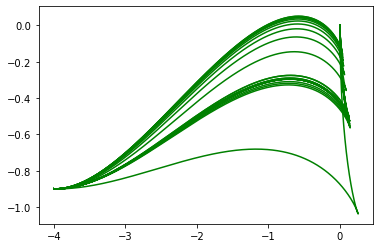

In [12]:
res = pdfo( Unicycle, [0.5, 0.5], bounds=bounds, constraints=[lin_con], options=options)
c1,c2= res.x



In [13]:
X1P_PDFO,X2P_PDFO,X3P_PDFO = DOC_Unicycle_PDFO (Xi, Xf, c1,c2)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:     2000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1000

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

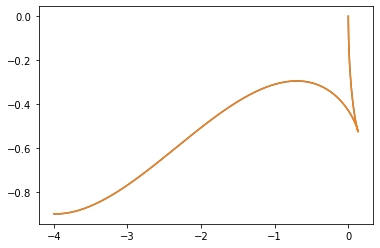

In [14]:
plt.plot(X1,X2)
plt.plot(X1P_PDFO,X2P_PDFO)